<a href="https://colab.research.google.com/github/saiparsa/Abnormal_Event_Detection/blob/master/Fine_Tuning_BlueBERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Using GPU for training

In [1]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [2]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla V100-SXM2-16GB


## Installing Hugging Face transformers

In [3]:
!pip install transformers

## Importing packages

In [4]:
import pandas as pd
import nltk.tokenize.treebank as tb
import re
import torch
import numpy as np
import pickle

from transformers import AutoTokenizer, AutoModel

## Mounting Drive and Loading Data

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
cd drive/My\ Drive/LAIDEL/  

/content/drive/My Drive/LAIDEL


In [7]:
data = pd.read_excel ('Data_v1.xlsx')
#data.text=data.text.astype(str)
data.head()

,phenotype_mim_num,gene_mim_num,Entrez Gene ID (NCBI),Approved Gene Symbol (HGNC),mutation_consequence,text
0,300983,300838,9758.0,FRMPD4,HI,In 5 affected males from a family (P58) with X...
1,618394,605394,60468.0,BACH2,DN,In a 19-year-old woman (family A) with immunod...
2,229100,606806,10841.0,FTCD,HI,In 2 sibs with glutamate formiminotransferase ...
3,616324,100725,1145.0,CHRNE,HI,For discussion of the ser143-to-leu (S143L) mu...
4,104300,104760,351.0,APP,none,In a cohort of 65 families with autosomal domi...


In [8]:
data.mutation_consequence.value_counts()

GOF     100
none    100
HI      100
LOF     100
DN      100
Name: mutation_consequence, dtype: int64

## Data Preprocessing

In [9]:
# Removing nan values
data.dropna(inplace=True)

In [10]:
data.mutation_consequence.value_counts()

LOF     100
DN      100
GOF      99
HI       99
none     84
Name: mutation_consequence, dtype: int64

In [11]:
# Get the lists of sentences and their labels.
sentences = data.text.values
labels = data.mutation_consequence.values

In [12]:
# Removing information which makes classification straight forward leading to overfitting
def remove_text_inside_brackets(text, brackets="()[]{}"):
    count = [0] * (len(brackets) // 2) # count open/close brackets
    saved_chars = []
    for character in text:
        for i, b in enumerate(brackets):
            if character == b: # found bracket
                kind, is_close = divmod(i, 2)
                count[kind] += (-1)**is_close # `+1`: open, `-1`: close
                if count[kind] < 0: # unbalanced bracket
                    count[kind] = 0  # keep it
                else:  # found bracket to remove
                    break
        else: # character is not a [balanced] bracket
            if not any(count): # outside brackets
                saved_chars.append(character)
    return ''.join(saved_chars)


In [13]:
sample = sentences[10]
sample #before preprocessing

'In affected members of a 3-generation family with thrombocytopenia-6 (THC6; {616937}), {22:Turro et al. (2016)} identified a heterozygous c.1579G-A transition in the SRC gene, resulting in a glu527-to-lys (E527K) substitution at a conserved residue in the kinase domain. The mutation, which was found by exome sequencing and confirmed by Sanger sequencing, segregated with the disorder in the family and was not found in the ExAC database or in 2,974 in-house control subjects. In vitro functional expression assays showed that the mutation resulted in high kinase activity compared to wildtype, consistent with a dominant gain of function. Immunoblot analysis of patient cells showed increased levels of active SRC and overall increased tyrosine phosphorylation compared to controls. Transfection of the mutation into control blood stem cells caused defective megakaryopoiesis associated with increased overall tyrosine phosphorylation in megakaryocytes. Compared with control conditions, more mega

In [14]:
sample = sample.lower() #converting into lowercase
sample = re.sub(r'[\r\n\n]+', ' ', sample)#removing the new line, carriage return sequences
sample = re.sub(r'[^\x00-\x7F]+', ' ', sample)#removing the special charecters
sample = remove_text_inside_brackets(sample) #removing text inside the braces

sample #after preprocessing

'in affected members of a 3-generation family with thrombocytopenia-6 ,  identified a heterozygous c.1579g-a transition in the src gene, resulting in a glu527-to-lys  substitution at a conserved residue in the kinase domain. the mutation, which was found by exome sequencing and confirmed by sanger sequencing, segregated with the disorder in the family and was not found in the exac database or in 2,974 in-house control subjects. in vitro functional expression assays showed that the mutation resulted in high kinase activity compared to wildtype, consistent with a dominant gain of function. immunoblot analysis of patient cells showed increased levels of active src and overall increased tyrosine phosphorylation compared to controls. transfection of the mutation into control blood stem cells caused defective megakaryopoiesis associated with increased overall tyrosine phosphorylation in megakaryocytes. compared with control conditions, more megakaryocytes were immature and had defects in pro

In [15]:
def preprocessing(sample):

    sample = sample.lower() #converting into lowercase
    sample = re.sub(r'[\r\n\n]+', ' ', sample)#removing the new line, carriage return sequences
    sample = re.sub(r'[^\x00-\x7F]+', ' ', sample)#removing the special charecters
    #sample = remove_text_inside_brackets(sample) #removing text inside the braces

    tokenized = tb.TreebankWordTokenizer().tokenize(sample)
    sentence = ' '.join(tokenized)
    sentence = re.sub(r"\s's\b", "'s", sentence)

    return sentence

In [16]:
data.text = data.text.apply(lambda x: preprocessing(x))

In [17]:
# Get the lists of sentences and their labels.
data['mutation_consequence'] = data['mutation_consequence'].astype('category')
# Assigning numerical values and storing in another column
data['labels'] = data['mutation_consequence'].cat.codes

sentences = data.text.values
labels = data.labels.values

## Tokenization & Input Formatting

In [18]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BlueBERT tokenizer...')

tokenizer = AutoTokenizer.from_pretrained("bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12")

Loading BlueBERT tokenizer...


In [19]:
# Print the original sentence.
print(' Original: ', sentences[10])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[10]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[10])))

 Original:  in affected members of a 3-generation family with thrombocytopenia-6 ( thc6 ; { 616937 } ) , { 22 : turro et al. ( 2016 ) } identified a heterozygous c.1579g-a transition in the src gene , resulting in a glu527-to-lys ( e527k ) substitution at a conserved residue in the kinase domain. the mutation , which was found by exome sequencing and confirmed by sanger sequencing , segregated with the disorder in the family and was not found in the exac database or in 2,974 in-house control subjects. in vitro functional expression assays showed that the mutation resulted in high kinase activity compared to wildtype , consistent with a dominant gain of function. immunoblot analysis of patient cells showed increased levels of active src and overall increased tyrosine phosphorylation compared to controls. transfection of the mutation into control blood stem cells caused defective megakaryopoiesis associated with increased overall tyrosine phosphorylation in megakaryocytes. compared with 

In [20]:
# Tokenizing
max_len = 0

# For every sentence...
for sent in sentences:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  8388


In [21]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
   
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels,dtype=torch.long)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[10])
print('Token IDs:', input_ids[10])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2143: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  in affected members of a 3-generation family with thrombocytopenia-6 ( thc6 ; { 616937 } ) , { 22 : turro et al. ( 2016 ) } identified a heterozygous c.1579g-a transition in the src gene , resulting in a glu527-to-lys ( e527k ) substitution at a conserved residue in the kinase domain. the mutation , which was found by exome sequencing and confirmed by sanger sequencing , segregated with the disorder in the family and was not found in the exac database or in 2,974 in-house control subjects. in vitro functional expression assays showed that the mutation resulted in high kinase activity compared to wildtype , consistent with a dominant gain of function. immunoblot analysis of patient cells showed increased levels of active src and overall increased tyrosine phosphorylation compared to controls. transfection of the mutation into control blood stem cells caused defective megakaryopoiesis associated with increased overall tyrosine phosphorylation in megakaryocytes. compared with c

## Training & Validation Split

In [22]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

  433 training samples
   49 validation samples


In [23]:
# creating data loaders
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 32 #recommended

train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

## Trainig the classification model

In [24]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12", # Use the 12-layer blueBERT model, with an uncased vocab.
    num_labels = 5, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSeque

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [25]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


In [26]:
from transformers import get_linear_schedule_with_warmup

epochs = 10

total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [27]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [28]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [31]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128



training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    # print("")
    # print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    # print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
           # print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        # print(b_labels[0])
        
        model.zero_grad()        
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)[:2]
        # print(model(b_input_ids, 
        #                      token_type_ids=None, 
        #                      attention_mask=b_input_mask, 
        #                      labels=b_labels)[:2])

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    # print("")
    # print("  Average training loss: {0:.2f}".format(avg_train_loss))
    # print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # print("")
    # print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)[:2]
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    # print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    # print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    # print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


Training complete!
Total training took 0:00:21 (h:mm:ss)


In [32]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,1.60,1.61,0.19,0:00:02,0:00:00
2,1.56,1.62,0.26,0:00:02,0:00:00
3,1.51,1.62,0.26,0:00:02,0:00:00
4,1.46,1.67,0.18,0:00:02,0:00:00
5,1.39,1.69,0.24,0:00:02,0:00:00
6,1.35,1.75,0.20,0:00:02,0:00:00
7,1.30,1.72,0.24,0:00:02,0:00:00
8,1.28,1.74,0.23,0:00:02,0:00:00
9,1.26,1.75,0.22,0:00:02,0:00:00


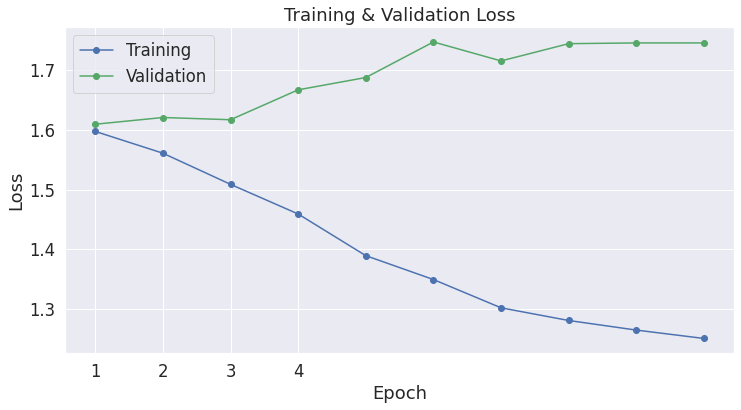

In [33]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()